# Dataset 2: Human Pancreas
Batch Effect Cause: Different technology, different tissues

## Importing Libraries

In [1]:
# --- General Libraries ---
import os  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns  
from typing import Dict, List, Tuple 

# --- Data Science and Bioinformatics Libraries ---
import anndata  
import scanpy as sc  
from scipy.sparse import csr_matrix  
from scipy.stats import ttest_ind  
from sklearn.preprocessing import scale  
from sklearn.metrics.pairwise import euclidean_distances  
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

# --- Specialized Libraries ---
import pyliger  
from harmony import harmonize
from combat.pycombat import pycombat

# --- Custom ---
from utils import *  
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import silhouette_score as asw, adjusted_rand_score as ari
from lisi import *

C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument 

In [2]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.

    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.

    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels[cell_neighbors]
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score

from sklearn.metrics import silhouette_score
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    embeddings = data[embeddings_columns].values  # Get the embedding coordinates
    labels = data[labels_column].values  # Get the labels
    asw_score = silhouette_score(embeddings, labels)  # Calculate silhouette score
    return asw_score

def compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw):
    """
    Computes and prints various metrics for a given embedding and metadata.

    Parameters:
    embedding (pd.DataFrame): DataFrame containing embedding coordinates.
    metadata (pd.DataFrame): DataFrame containing metadata (e.g., batch, cell type).
    compute_lisi (function): Function to compute LISI scores.
    calculate_kbet (function): Function to calculate kBET scores.
    calculate_asw (function): Function to calculate ASW scores.

    Returns:
    None
    """
    import time

    start_time = time.time()

    # Convert to a DataFrame for alignment with metadata
    embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

    # Ensure metadata categories
    metadata['batch'] = metadata['batch'].astype('category')
    metadata['CellType'] = metadata['CellType'].astype('category')

    # Compute LISI scores
    label_colnames = ["batch", "CellType"]
    lisi_scores = compute_lisi(
        X=embedding[["tsne1", "tsne2"]].values,
        metadata=metadata,
        label_colnames=label_colnames,
        perplexity=30
    )

    # Separate LISI scores
    lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
    lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

    # Print LISI results
    print("Batch Mean LISI Scores:", lisi_batch.mean())
    print("Batch Median LISI Scores:", np.median(lisi_batch))
    print("Celltype Mean LISI Scores:", lisi_celltype.mean())
    print("Celltype Median LISI Scores:", np.median(lisi_celltype))

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=20)
    print(f"kBET score 20: {kbet_score}")
    
    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=30)
    print(f"kBET score 30: {kbet_score}")

    # Compute kBET score
    kbet_score = calculate_kbet(embedding[["tsne1", "tsne2"]].values, metadata['batch'].values, k=40)
    print(f"kBET score 40: {kbet_score}")

    # Compute ASW scores
    embedding_columns = ['tsne1', 'tsne2']
    embedding_df['CellType'] = metadata['CellType'].astype('category')
    embedding['CellType'] = embedding_df.reset_index()['CellType']
    
    # Calculate ASW for CellType
    asw_celltype = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='CellType')
    print(f"ASW (CellType): {asw_celltype}")

    # Calculate ASW for batches (datasets)
    asw_batch = calculate_asw(embedding, embeddings_columns=embedding_columns, labels_column='Dataset')
    print(f"ASW (Batch): {asw_batch}")

    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")

CPU times: total: 0 ns
Wall time: 0 ns


## Importing Dataset

In [3]:
%%time

# Directories
read_dir = r"C:/Users/namra/Emlyon/30 Master's Thesis/data/dataset_human_pancreas/"

# Filenames
expr_filename = 'myData_pancreatic_5batches.txt'
metadata_filename = 'mySample_pancreatic_5batches.txt'

batch_label = "batchlb"
celltype_label = "CellType"

# Constructing file paths
expr_filepath = os.path.join(read_dir, expr_filename)
metadata_filepath = os.path.join(read_dir, metadata_filename)

# Read expression matrix and metadata into dfs
expr_mat = pd.read_csv(expr_filepath, sep='\t', header=0, index_col=0)
metadata = pd.read_csv(metadata_filepath, sep='\t', header=0, index_col=0)

# Rename the 'ct' column in metadata to 'CellType'
metadata.rename(columns={'celltype': 'CellType'}, inplace=True)

# Filter the expression matrix to include only columns present in the metadata
expr_mat = expr_mat.loc[:, metadata.index]

# Check the resulting expression matrix and metadata
display(expr_mat.head())
display(metadata.head())


,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,Sample_1589,Sample_1590,Sample_1591,Sample_1592,Sample_1593,Sample_1594,Sample_1595,Sample_1597,Sample_1598,Sample_1600
A1BG,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.3304,2.4857,0.0000,8.1498,0.5372,31.1225,0.5788
A1CF,4,0,0,0,0,1,0,1,0,0,...,6.8671,11.9884,26.3156,0.0000,5.0270,151.0094,0.8452,12.7441,0.9078,0.6753
A2M,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,batch,batchlb,celltype_orig,cellname,CellType
human1_lib1.final_cell_0001,1,Baron_b1,acinar,human1_lib1.final_cell_0001,acinar
human1_lib1.final_cell_0002,1,Baron_b1,acinar,human1_lib1.final_cell_0002,acinar
human1_lib1.final_cell_0003,1,Baron_b1,acinar,human1_lib1.final_cell_0003,acinar
human1_lib1.final_cell_0004,1,Baron_b1,acinar,human1_lib1.final_cell_0004,acinar
human1_lib1.final_cell_0005,1,Baron_b1,acinar,human1_lib1.final_cell_0005,acinar


CPU times: total: 26.7 s
Wall time: 36.2 s


In [3]:
# Ensure metadata indices match expression matrix columns
expr_mat = expr_mat.loc[:, metadata.index]

# EDA: Quick summary of data
print("Metadata head:")
display(metadata.head())
print("\nExpression matrix dimensions:", expr_mat.shape)

Metadata head:


,batch,batchlb,celltype_orig,cellname,CellType
human1_lib1.final_cell_0001,1,Baron_b1,acinar,human1_lib1.final_cell_0001,acinar
human1_lib1.final_cell_0002,1,Baron_b1,acinar,human1_lib1.final_cell_0002,acinar
human1_lib1.final_cell_0003,1,Baron_b1,acinar,human1_lib1.final_cell_0003,acinar
human1_lib1.final_cell_0004,1,Baron_b1,acinar,human1_lib1.final_cell_0004,acinar
human1_lib1.final_cell_0005,1,Baron_b1,acinar,human1_lib1.final_cell_0005,acinar



Expression matrix dimensions: (15558, 14767)


In [4]:
# EDA: Check for missing values
print("\nMetadata missing values:")
print(metadata.isnull().sum())
print("\nExpression matrix missing values:")
print(expr_mat.isnull().sum().sum())


Metadata missing values:
batch            0
batchlb          0
celltype_orig    0
cellname         0
celltype         0
dtype: int64

Expression matrix missing values:
0


In [4]:
%%time

print("\nCell Type Distribution:")
display(metadata['CellType'].value_counts())
    
print("\nBatch Distribution:")
display(metadata['batch'].value_counts())


Cell Type Distribution:


CellType
alpha           5100
beta            3826
ductal          1804
acinar          1368
delta            966
gamma            656
stellate         511
endothelial      289
mesenchymal      107
macrophage        55
mast              32
epsilon           28
schwann           13
t_cell             7
MHC class II       5
Name: count, dtype: int64


Batch Distribution:


batch
1    8569
3    2127
2    2122
5    1492
4     457
Name: count, dtype: int64

CPU times: total: 0 ns
Wall time: 9.73 ms


C:\Users\namra\AppData\Local\Temp\ipykernel_4952\1046193730.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



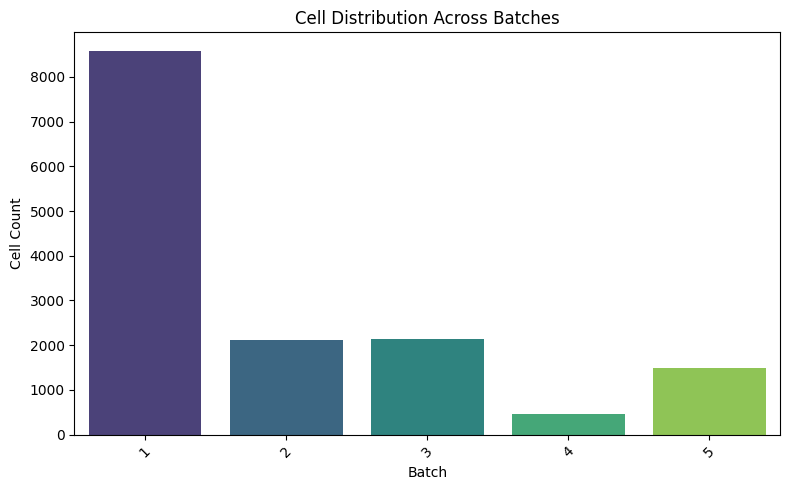

In [5]:
# EDA: Distribution of cells per batch
plt.figure(figsize=(8, 5))
sns.countplot(data=metadata, x='batch', palette="viridis")
plt.title("Cell Distribution Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

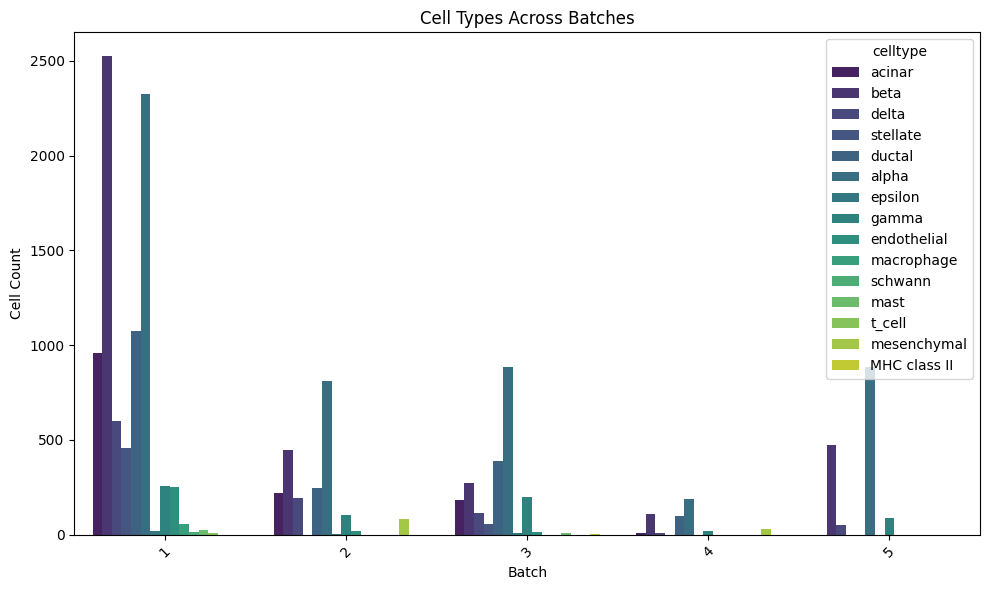

In [7]:
# EDA: Cell types per batch
plt.figure(figsize=(10, 6))
sns.countplot(data=metadata, x='batch', hue='celltype', palette="viridis")
plt.title("Cell Types Across Batches")
plt.xlabel("Batch")
plt.ylabel("Cell Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

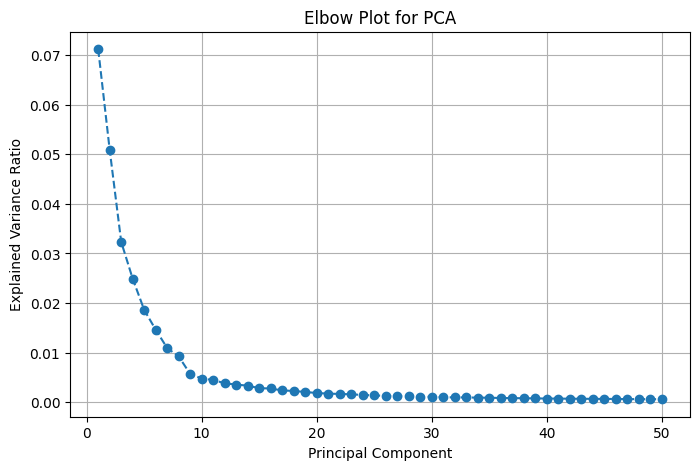

CPU times: total: 49.2 s
Wall time: 23.6 s


In [4]:
%%time

# Create AnnData object
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize and log transform data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Compute PCA with more components to check explained variance
sc.tl.pca(adata, svd_solver='arpack')

# Plot the explained variance ratio
explained_variance_ratio = adata.uns['pca']['variance_ratio']

# Elbow plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()


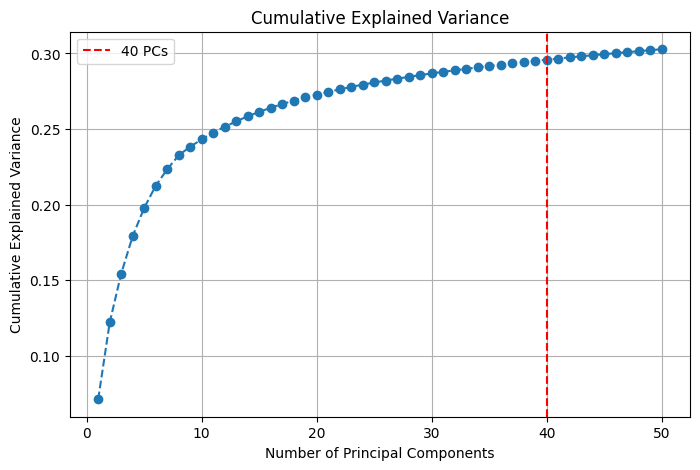

Variance explained by first 50 PCs: 30.28%
Variance explained by first 40 PCs: 29.59%
Variance explained by first 30 PCs: 28.68%
Variance explained by first 20 PCs: 27.28%
Variance explained by first 10 PCs: 24.31%
CPU times: total: 46.9 ms
Wall time: 129 ms


In [5]:
%%time

# Cumulative explained variance
cumulative_variance = np.cumsum(adata.uns['pca']['variance_ratio'])

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(40, color='r', linestyle='--', label='40 PCs')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.savefig("cumulative_variance_plot.png")
plt.show()

# Print explained variance captured by 40 PCs
print(f"Variance explained by first 50 PCs: {cumulative_variance[49]:.2%}")
print(f"Variance explained by first 40 PCs: {cumulative_variance[39]:.2%}")
print(f"Variance explained by first 30 PCs: {cumulative_variance[29]:.2%}")
print(f"Variance explained by first 20 PCs: {cumulative_variance[19]:.2%}")
print(f"Variance explained by first 10 PCs: {cumulative_variance[9]:.2%}")

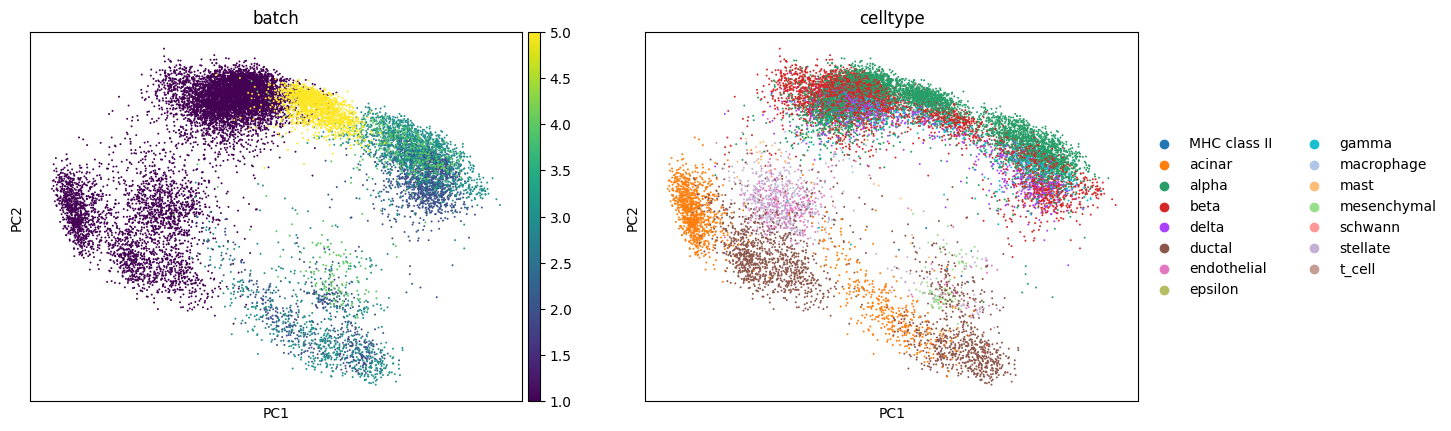

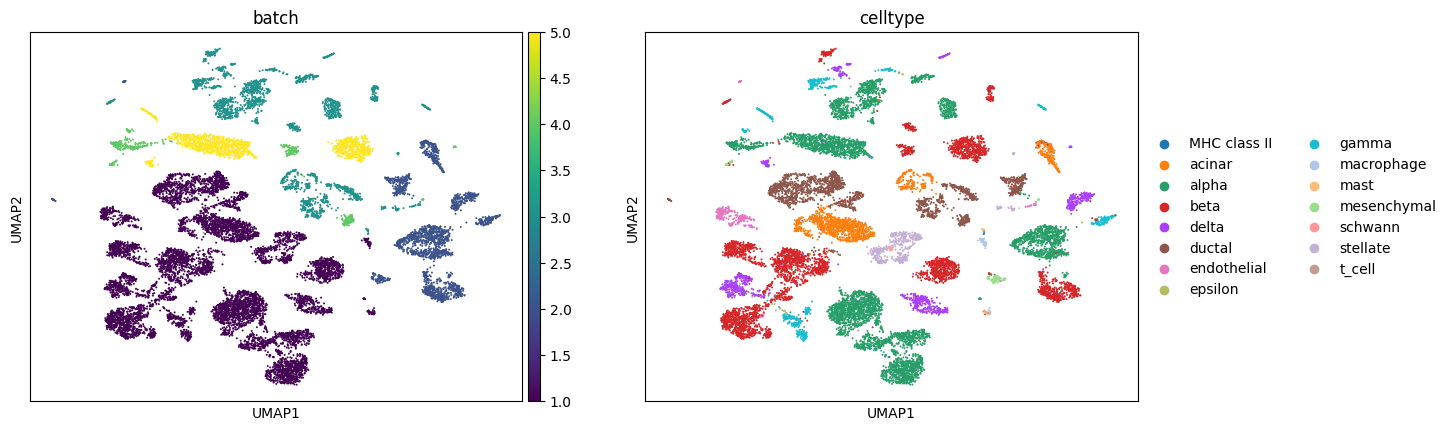

In [10]:
# Prepare data for Scanpy AnnData
adata = sc.AnnData(X=expr_mat.T, obs=metadata)

# Normalize and log transform data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Run PCA
sc.tl.pca(adata)
sc.pl.pca(adata, color=['batch', 'celltype'], save="_pca_plot.png")  # Save plot as file

# Compute neighbors and run UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'celltype'], save="_umap_plot.png")  # Save plot as file


## LIGER
https://github.com/welch-lab/pyliger/blob/master/integrating_multi_scRNA_data.ipynb

In [ ]:
batch_label='batchlb'
celltype_label='CellType' 
    
# Check if batch_label exists in metadata
if batch_label not in metadata.columns:
    raise ValueError(f"'{batch_label}' not found in metadata columns.")

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    if not cell_names.is_unique:
        raise ValueError(f"Cell names are not unique in batch {batch}. Please ensure all cell names are unique.")
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    if not gene_names.is_unique:
        raise ValueError(f"Gene names are not unique in the expression matrix. Please ensure all gene names are unique.")
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    # Explicitly set names for obs and var indices
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    # Add the 'sample_name' key to uns (if not already there)
    adata.uns['sample_name'] = batch  # Assign the batch name as sample name
    
    # Check that indices are unique and populated
    if not adata.obs.index.is_unique:
        raise ValueError(f"Cell names are not unique in the AnnData object for batch {batch}.")
    
    if not adata.var.index.is_unique:
        raise ValueError(f"Gene names are not unique in the AnnData object for batch {batch}.")
    
    # Debugging output
    print(f"Batch: {batch}, Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
    
    # Verify that the AnnData object has both row (cell) and column (gene) names
    print(f"First 5 cell names: {adata.obs.index[:5]}")
    print(f"First 5 gene names: {adata.var.index[:5]}")
    
    adata_list.append(adata)

# Debug: Check if adata_list is populated
if not adata_list:
    raise ValueError("No valid AnnData objects were created. Please check the batch labels and cell alignment.")

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise


Batch: Baron_b1, Number of cells: 8569, Number of genes: 15558
First 5 cell names: Index(['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0002',
       'human1_lib1.final_cell_0003', 'human1_lib1.final_cell_0004',
       'human1_lib1.final_cell_0005'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Mutaro_b2, Number of cells: 2122, Number of genes: 15558
First 5 cell names: Index(['D28.1_1', 'D28.1_13', 'D28.1_15', 'D28.1_17', 'D28.1_2'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Segerstolpe_b3, Number of cells: 2127, Number of genes: 15558
First 5 cell names: Index(['AZ_A10', 'AZ_A11', 'AZ_A12', 'AZ_A2', 'AZ_A5'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Wang_b4, Num

100%|██████████| 30/30 [07:02<00:00, 14.08s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


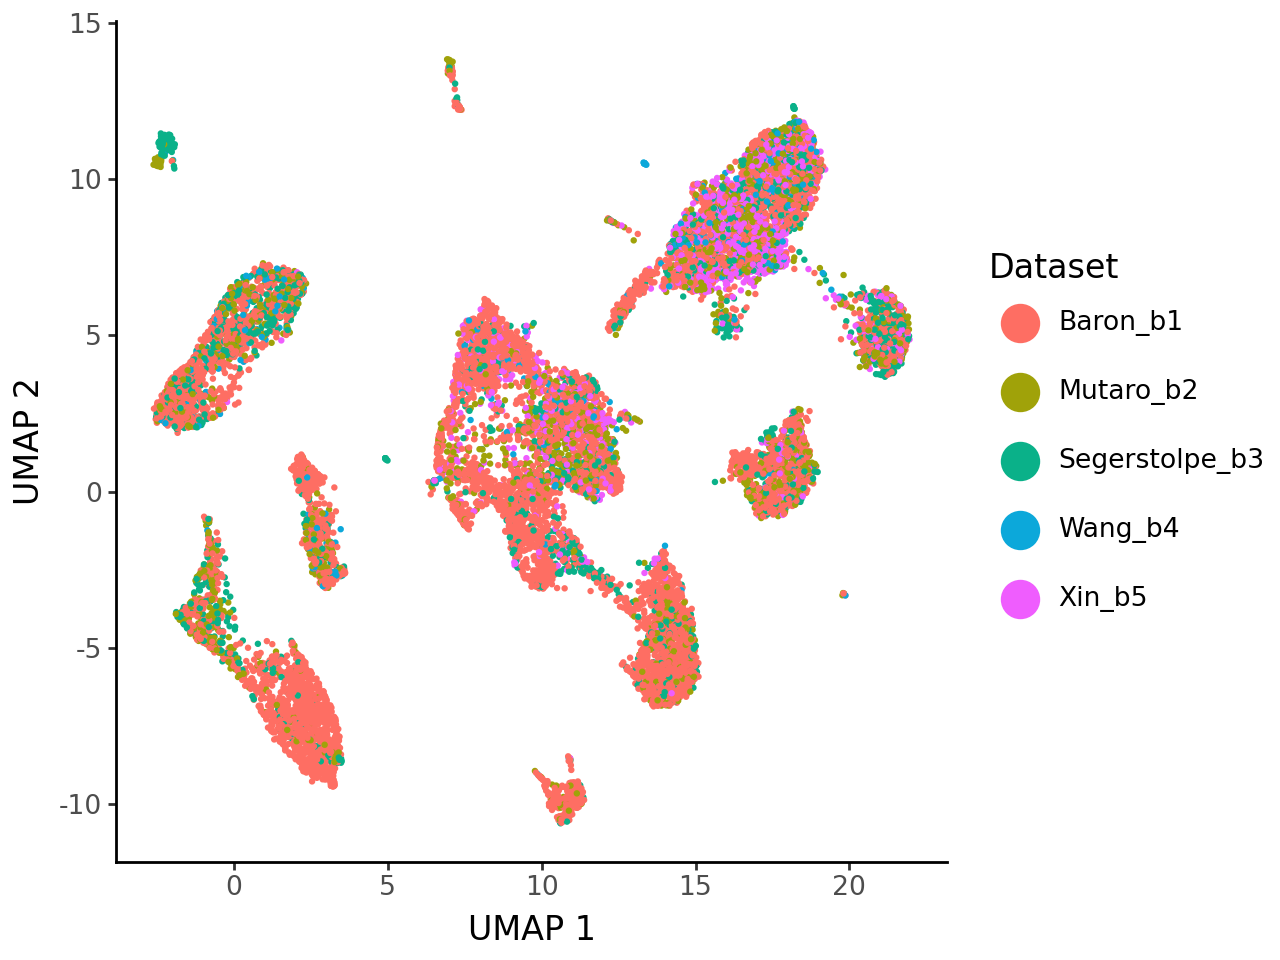

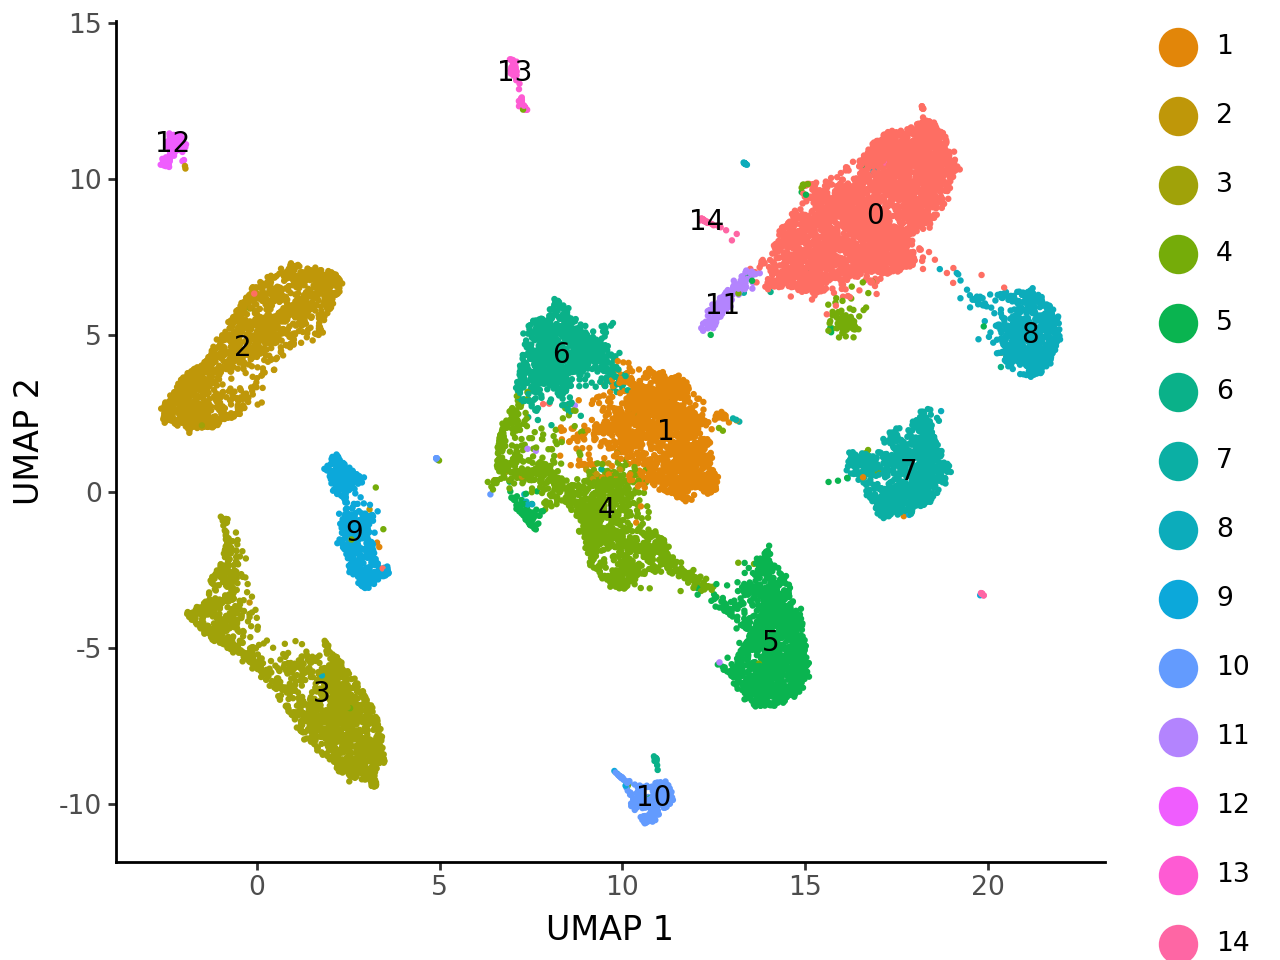

Performing Wilcoxon test on ALL datasets: Baron_b1, Mutaro_b2, Segerstolpe_b3, Wang_b4, Xin_b5
CPU times: total: 15min 27s
Wall time: 8min 20s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [6]:
%%time

k=20 
var_thresh=0.1

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=30, min_dist=0.3)
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")
embedding = liger_object.tsne_coords

In [7]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 2.2407901390471188
Batch Median LISI Scores: 2.1785620425636765
Celltype Mean LISI Scores: 1.1281982296703867
Celltype Median LISI Scores: 1.007056955831854
kBET score 20: 0.5226620166587662
kBET score 30: 0.5109884652716643
kBET score 40: 0.5037617661000879
ASW (CellType): 0.19709502160549164
ASW (Batch): -0.09305575489997864
Execution Time: 14.46352243423462 seconds


100%|██████████| 30/30 [15:00<00:00, 30.00s/it]
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyliger\plotting\_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


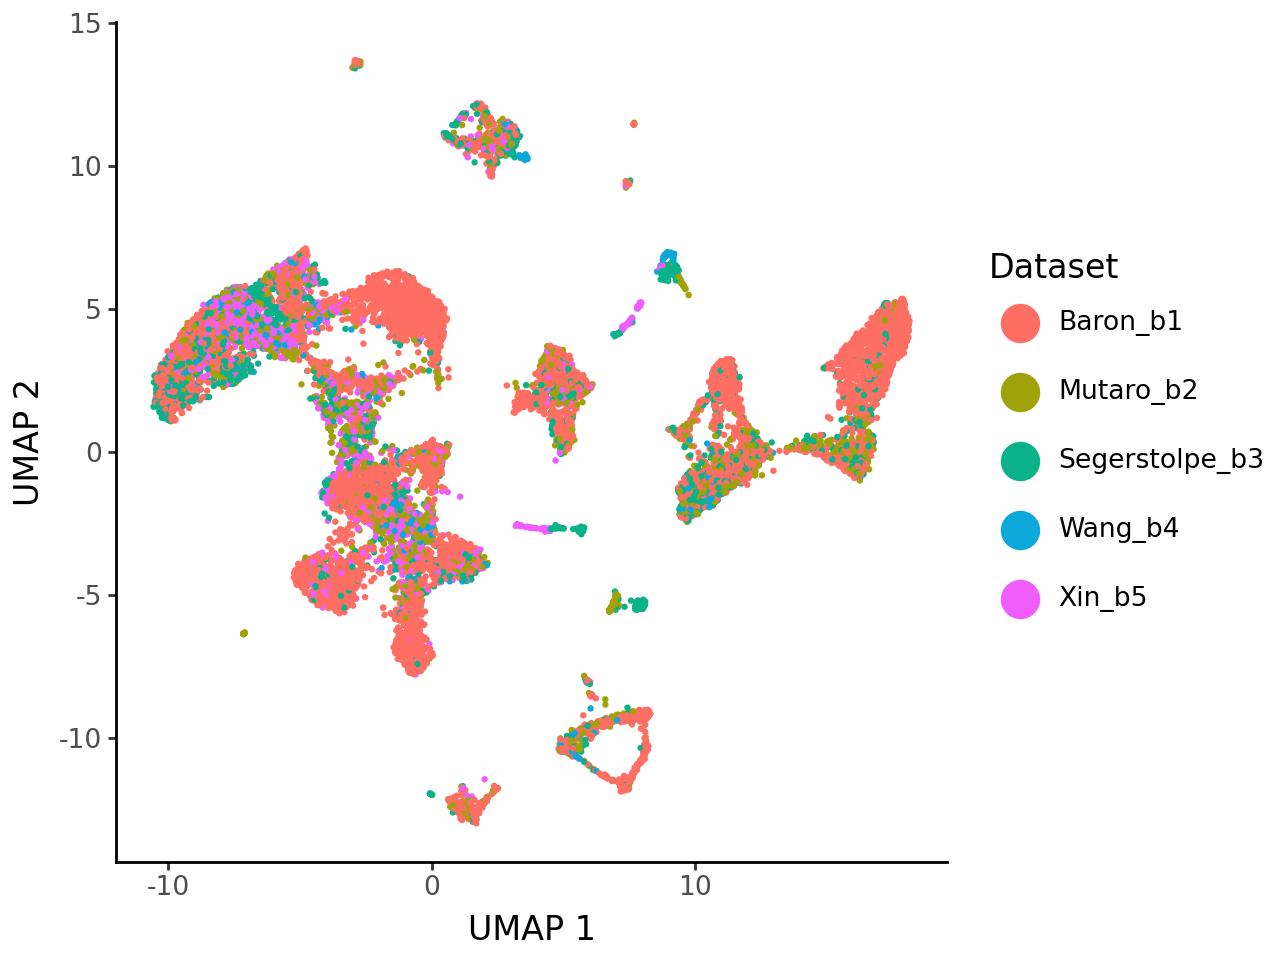

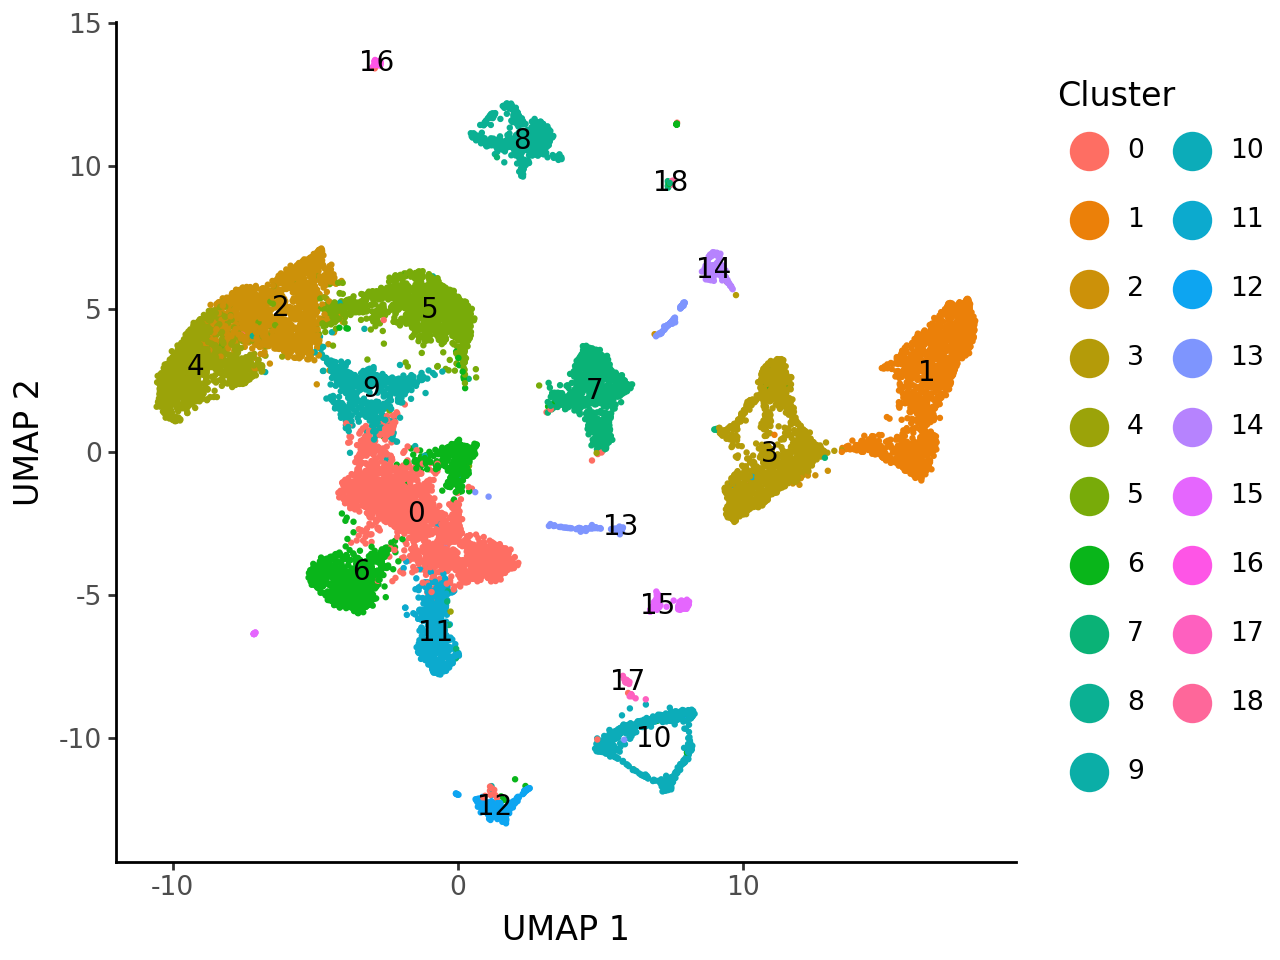

Performing Wilcoxon test on ALL datasets: Baron_b1, Mutaro_b2, Segerstolpe_b3, Wang_b4, Xin_b5
CPU times: total: 18min 56s
Wall time: 16min 16s


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [8]:
%%time

k=30
var_thresh=0.1

try:
    # Create LIGER object from the list of AnnData objects
    liger_object = pyliger.create_liger(adata_list)
except ValueError as e:
    print(f"ValueError occurred while creating LIGER object: {e}")
    print("adata_list:", adata_list)
    raise

# Preprocessing steps (separate function calls)
pyliger.normalize(liger_object)  # Normalize the LIGER object
pyliger.select_genes(liger_object, var_thresh=var_thresh)  # Select variable genes
pyliger.scale_not_center(liger_object)  # Scale data without centering

# Factorization and alignment
pyliger.optimize_ALS(liger_object, k=k, nrep = 1)  # Perform ALS optimization

# Quantile Normalization and Clustering
pyliger.quantile_norm(liger_object)
pyliger.leiden_cluster(liger_object, resolution=0.25)

# Visualization
pyliger.run_umap(liger_object, distance='cosine', n_neighbors=40, min_dist=0.3)
embedding = liger_object.tsne_coords
plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels=['UMAP 1', 'UMAP 2'], return_plots=True)

for plot in plots:
    plt.figure(figsize=(8, 6))
    plot.show()

# Downstream Analysis
cluster_results = pyliger.run_wilcoxon(liger_object, compare_method="clusters")

In [9]:
compute_and_print_metrics(embedding, metadata, compute_lisi, calculate_kbet, calculate_asw)

Batch Mean LISI Scores: 2.069105409935267
Batch Median LISI Scores: 1.928590905832386
Celltype Mean LISI Scores: 1.1097719261461134
Celltype Median LISI Scores: 1.0079546341826122
kBET score 20: 0.5904313672377598
kBET score 30: 0.5777792826347036
kBET score 40: 0.5694961739012664
ASW (CellType): 0.3901236057281494
ASW (Batch): -0.1327887624502182
Execution Time: 14.665677309036255 seconds


## HARMONY

Batch: Baron_b1, Number of cells: 8569, Number of genes: 15558
First 5 cell names: Index(['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0002',
       'human1_lib1.final_cell_0003', 'human1_lib1.final_cell_0004',
       'human1_lib1.final_cell_0005'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Mutaro_b2, Number of cells: 2122, Number of genes: 15558
First 5 cell names: Index(['D28.1_1', 'D28.1_13', 'D28.1_15', 'D28.1_17', 'D28.1_2'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Segerstolpe_b3, Number of cells: 2127, Number of genes: 15558
First 5 cell names: Index(['AZ_A10', 'AZ_A11', 'AZ_A12', 'AZ_A2', 'AZ_A5'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Wang_b4, Num

<timed exec>:54: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


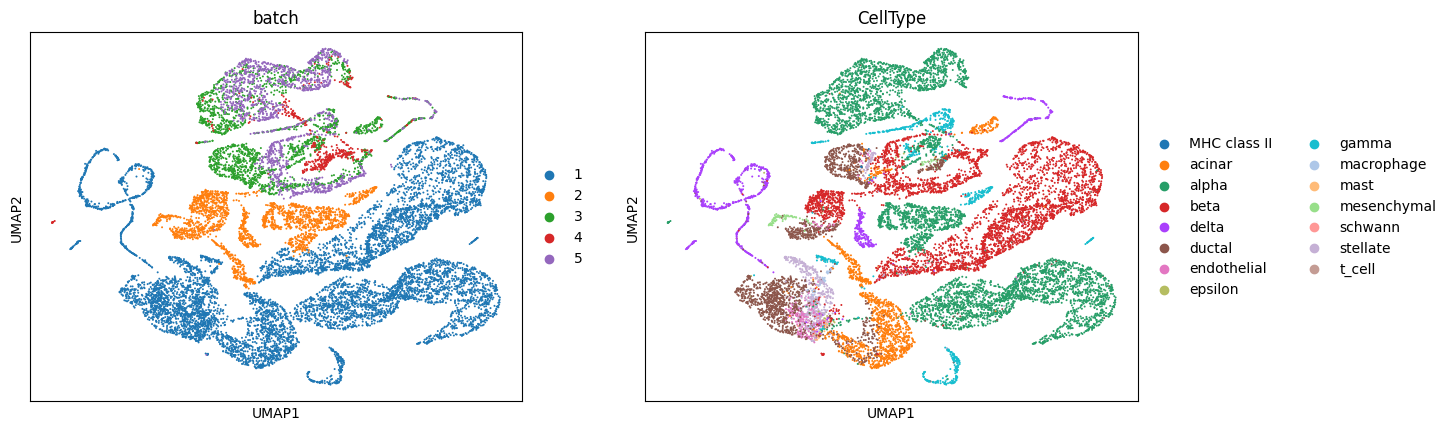

CPU times: total: 4min 11s
Wall time: 1min 50s


In [10]:
%%time

# Check if batch_label exists in metadata
if batch_label not in metadata.columns:
    raise ValueError(f"'{batch_label}' not found in metadata columns.")

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    if not cell_names.is_unique:
        raise ValueError(f"Cell names are not unique in batch {batch}. Please ensure all cell names are unique.")
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    if not gene_names.is_unique:
        raise ValueError(f"Gene names are not unique in the expression matrix. Please ensure all gene names are unique.")
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    # Explicitly set names for obs and var indices
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    # Add the 'sample_name' key to uns (if not already there)
    adata.uns['sample_name'] = batch  # Assign the batch name as sample name
    
    # Check that indices are unique and populated
    if not adata.obs.index.is_unique:
        raise ValueError(f"Cell names are not unique in the AnnData object for batch {batch}.")
    
    if not adata.var.index.is_unique:
        raise ValueError(f"Gene names are not unique in the AnnData object for batch {batch}.")
    
    # Debugging output
    print(f"Batch: {batch}, Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
    
    # Verify that the AnnData object has both row (cell) and column (gene) names
    print(f"First 5 cell names: {adata.obs.index[:5]}")
    print(f"First 5 gene names: {adata.var.index[:5]}")
    
    adata_list.append(adata)
# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=10,                
    max_iter_harmony=10,           
    max_iter_clustering=200,       
    tol_harmony=1e-4,              
    tol_clustering=1e-5,          
    ridge_lambda=1.0,           
    sigma=0.1,                     
    block_proportion=0.05,         
    theta=2.0,                    
    tau=0,                         
    correction_method='fast',     
    random_state=0,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(combined_adata)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'])

In [18]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

Batch Mean LISI Scores: 1.087069719333043
Batch Median LISI Scores: 1.0000000000000002
Celltype Mean LISI Scores: 1.1349617008292219
Celltype Median LISI Scores: 1.001198022316572
CPU times: total: 9.48 s
Wall time: 9.87 s


In [20]:
%%time

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.9167908173630392
CPU times: total: 1.52 s
Wall time: 1.71 s


In [23]:
# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")


ASW (CellType): -0.7536419034004211
ASW (Batch): 0.17916251718997955


Batch: Baron_b1, Number of cells: 8569, Number of genes: 15558
First 5 cell names: Index(['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0002',
       'human1_lib1.final_cell_0003', 'human1_lib1.final_cell_0004',
       'human1_lib1.final_cell_0005'],
      dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Mutaro_b2, Number of cells: 2122, Number of genes: 15558
First 5 cell names: Index(['D28.1_1', 'D28.1_13', 'D28.1_15', 'D28.1_17', 'D28.1_2'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Segerstolpe_b3, Number of cells: 2127, Number of genes: 15558
First 5 cell names: Index(['AZ_A10', 'AZ_A11', 'AZ_A12', 'AZ_A2', 'AZ_A5'], dtype='object', name='cell_names')
First 5 gene names: Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT'], dtype='object', name='gene_names')
Batch: Wang_b4, Num

<timed exec>:54: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


	Initialization is completed.
	Completed 1 / 25 iteration(s).
	Completed 2 / 25 iteration(s).
	Completed 3 / 25 iteration(s).
Reach convergence after 3 iteration(s).


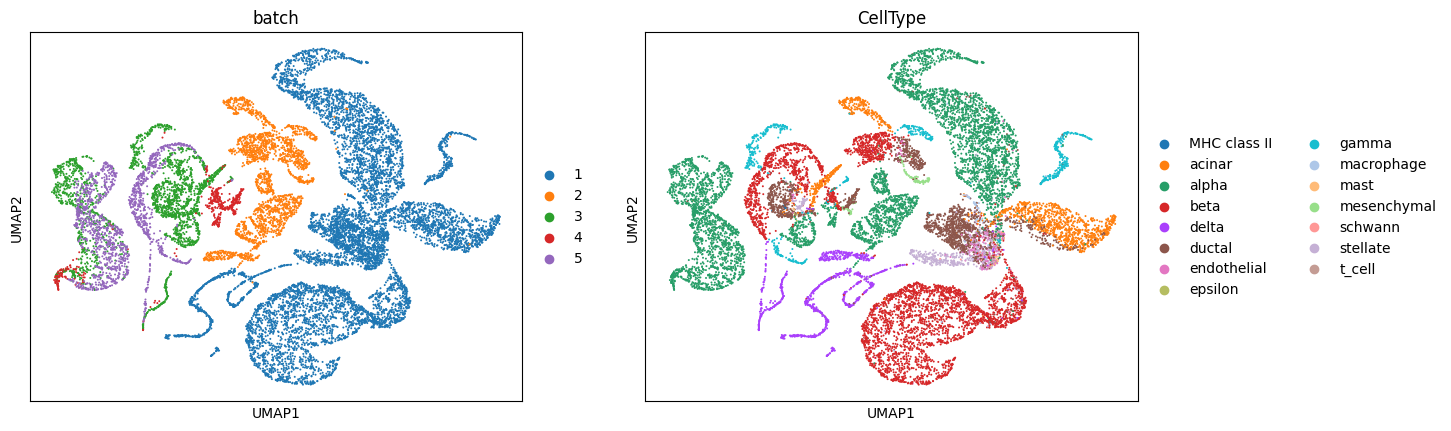

CPU times: total: 1min 5s
Wall time: 41 s


In [11]:
%%time

# Check if batch_label exists in metadata
if batch_label not in metadata.columns:
    raise ValueError(f"'{batch_label}' not found in metadata columns.")

# Separate datasets by batch
datasets = {}
for batch in metadata[batch_label].unique():
    batch_cells = metadata[metadata[batch_label] == batch].index
    datasets[batch] = expr_mat.loc[:, batch_cells]

# Convert each batch dataset into an AnnData object
adata_list = []
for batch, dataset in datasets.items():
    # Ensure unique cell names (obs)
    cell_names = dataset.columns
    if not cell_names.is_unique:
        raise ValueError(f"Cell names are not unique in batch {batch}. Please ensure all cell names are unique.")
    
    # Ensure unique gene names (var)
    gene_names = expr_mat.index
    if not gene_names.is_unique:
        raise ValueError(f"Gene names are not unique in the expression matrix. Please ensure all gene names are unique.")
    
    # Create an AnnData object for each batch dataset
    adata = sc.AnnData(
        X=dataset.T,  # Transpose the dataset to have cells as rows and genes as columns
        obs=metadata.loc[dataset.columns],  # Metadata corresponding to cells
        var=pd.DataFrame(index=expr_mat.index)  # Ensure 'var' is a DataFrame with gene names
    )
    
    # Explicitly set names for obs and var indices
    adata.obs.index.name = 'cell_names'
    adata.var.index.name = 'gene_names'
    
    # Add the 'sample_name' key to uns (if not already there)
    adata.uns['sample_name'] = batch  # Assign the batch name as sample name
    
    # Check that indices are unique and populated
    if not adata.obs.index.is_unique:
        raise ValueError(f"Cell names are not unique in the AnnData object for batch {batch}.")
    
    if not adata.var.index.is_unique:
        raise ValueError(f"Gene names are not unique in the AnnData object for batch {batch}.")
    
    # Debugging output
    print(f"Batch: {batch}, Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
    
    # Verify that the AnnData object has both row (cell) and column (gene) names
    print(f"First 5 cell names: {adata.obs.index[:5]}")
    print(f"First 5 gene names: {adata.var.index[:5]}")
    
    adata_list.append(adata)
# Now, perform Harmony on the combined AnnData object instead of a single batch
combined_adata = adata_list[0].concatenate(adata_list[1:], batch_key=batch_label)

# Ensure PCA is already computed (if not, run PCA)
sc.tl.pca(combined_adata, svd_solver='arpack')

# Apply Harmony to the PCA coordinates (on combined data)
combined_adata.obsm['X_pca_harmony'] = harmonize(
    combined_adata.obsm['X_pca'],  # PCA embeddings
    combined_adata.obs,            
    batch_key=batch_label,        
    n_clusters=15,                
    max_iter_harmony=25,           
    max_iter_clustering=200,       
    tol_harmony=1e-5,              
    tol_clustering=1e-5,          
    ridge_lambda=2.0,           
    sigma=0.2,                     
    block_proportion=0.1,         
    theta=3.0,                    
    tau=0,                         
    correction_method='fast',     
    random_state=0,               
    use_gpu=False,            
    n_jobs=-1,               
    verbose=True                 
)

# Replace PCA coordinates with Harmony-corrected embeddings
combined_adata.obsm['X_pca'] = combined_adata.obsm['X_pca_harmony']

# Recompute neighbors and UMAP using Harmony-corrected data
sc.pp.neighbors(combined_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(combined_adata)

# Plot UMAP with batch and cell type coloring
sc.pl.umap(combined_adata, color=['batch', 'CellType'])

In [15]:
%%time

# Embedding (Harmony-corrected PCA embeddings)
embedding = combined_adata.obsm['X_pca_harmony']  # Use Harmony embeddings (or UMAP/PCA)

# Convert embedding to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=combined_adata.obs.index, columns=[f'PCA{i+1}' for i in range(50)])

# Ensure metadata is aligned and categorical columns are set properly
combined_adata.obs['batch'] = combined_adata.obs['batch'].astype('category')
combined_adata.obs['CellType'] = combined_adata.obs['CellType'].astype('category')

# Call the compute_lisi function for both "batch" and "celltype"
label_colnames = ["batch", "CellType"]
lisi_scores = compute_lisi(
    X=embedding,         # Harmony embeddings (cells x dimensions)
    metadata=combined_adata.obs,  # Metadata with batch/celltype info
    label_colnames=label_colnames    # Adjust based on your dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

batch_labels = combined_adata.obs['batch']
kbet_score = calculate_kbet(embedding[:, :2], batch_labels, k=20)  # Use the first 2 columns
print(f"kBET score: {kbet_score}")

# Add the cluster labels to the embedding dataframe
embedding_df['CellType'] = combined_adata.obs['CellType'].values  # Replace with the actual column name

# Now compute ASW for clusters
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='CellType')
print(f"ASW (CellType): {asw_cluster}")

# Add the batch labels (or clusters, cell types) to the embedding dataframe
embedding_df['batch'] = combined_adata.obs['batch'].values  # Adjust for the correct label column

# Now compute ASW for clusters or batches
asw_cluster = calculate_asw(embedding_df, embeddings_columns=['PCA1', 'PCA2'], labels_column='batch')
print(f"ASW (Batch): {asw_cluster}")

Batch Mean LISI Scores: 1.0513918919298588
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.1421572422705037
Celltype Median LISI Scores: 1.0008368893820045


<timed exec>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


kBET score: 0.9474165368727568
ASW (CellType): -0.7683696150779724
ASW (Batch): 0.2268620729446411
CPU times: total: 27.2 s
Wall time: 17.5 s


## PYCOMBAT

In [17]:
%%time

# Step 1: Generate the batch list
batch_label = 'batch'
celltype_label = 'CellType'
datasets = []
batch = []
mod = []

for batch_index, batch_value in enumerate(metadata[batch_label].unique()):
    batch_cells = metadata[metadata[batch_label] == batch_value].index
    datasets.append(expr_mat.loc[:, batch_cells])
    batch.extend([batch_index] * len(batch_cells))
    
    # Add the corresponding cell types for the batch cells
    celltypes_for_batch = metadata.loc[batch_cells, celltype_label].values
    mod.extend(celltypes_for_batch)  # Collect cell type information as a covariate

# Concatenate all datasets by keeping only the common genes (inner join)
df_expression = pd.concat(datasets, axis=1, join="inner")

# from combat.pycombat import pycombat
df_corrected = pycombat(df_expression, batch)

Found 5 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide


Adjusting the Data
CPU times: total: 1min 19s
Wall time: 1min 46s


In [18]:
%%time

def calculate_kbet(embedding, labels, k=20):
    """
    Calculate the kBET score for batch correction.
    
    Parameters:
    - embedding: np.array, shape (n_cells, n_dimensions), t-SNE or UMAP embedding.
    - labels: list or np.array or pd.Series, cell labels (e.g., batch labels).
    - k: int, the number of nearest neighbors to consider.
    
    Returns:
    - kBET score: float, the proportion of neighbors from the same batch.
    """
    # Transpose the data if needed
    if embedding.shape[0] != len(labels):
        embedding = embedding.T
    
    # Ensure labels is a pandas Series
    if not isinstance(labels, pd.Series):
        labels = pd.Series(labels)
    
    # Validate input shapes
    if len(labels) != embedding.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embedding.shape[0]})")
    
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 to exclude self
    nn.fit(embedding)
    
    # Find k-nearest neighbors for each cell
    neighbors = nn.kneighbors(embedding, return_distance=False)
    
    # Count how many neighbors belong to the same batch
    kbet_scores = []
    for i, cell_neighbors in enumerate(neighbors):
        # Exclude self from neighbors
        cell_neighbors = cell_neighbors[1:]
        
        # Extract batch labels of the nearest neighbors
        neighbor_labels = labels.iloc[cell_neighbors]
        
        # Calculate the proportion of neighbors from the same batch
        same_batch_proportion = np.sum(neighbor_labels == labels.iloc[i]) / k
        kbet_scores.append(same_batch_proportion)
    
    # kBET score: the mean proportion of neighbors from the same batch
    kbet_score = np.mean(kbet_scores)
    return kbet_score

CPU times: total: 0 ns
Wall time: 1 ms


In [19]:
%%time

from sklearn.manifold import TSNE

# Assuming df_corrected is your corrected data matrix (cells x genes)
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(df_corrected.T)  # Transpose if needed (cells x genes -> genes x cells)

# Calculate kBET score
kbet_score = calculate_kbet(embedding, batch)
print(f"kBET Score: {kbet_score}")

# Convert to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

# Ensure that the 'batch' and 'CellType' are in the metadata and aligned with embedding_df
embedding_df['batch'] = metadata['batch']
embedding_df['CellType'] = metadata['CellType']

# Example call to compute LISI for both batch and cell type
label_colnames = ["batch", "CellType"]  # Modify as per your metadata
lisi_scores = compute_lisi(
    X=embedding_df[['UMAP1', 'UMAP2']],  # Using the embedding columns
    metadata=embedding_df,  # DataFrame with batch/celltype information
    label_colnames=label_colnames,
    perplexity=30           # Adjust perplexity based on dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

# ASW Calculation Function
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    # Extract embeddings
    embeddings = data[embeddings_columns].values
    
    # Validate labels
    labels = data[labels_column]  # Directly access the labels from the DataFrame
    
    # Check if lengths match
    if len(labels) != embeddings.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embeddings.shape[0]})")
    
    # Calculate silhouette score (ASW)
    asw_score = silhouette_score(embeddings, labels)
    return asw_score

# Calculate ASW for both "batch" and "CellType"
batch_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'batch')
celltype_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'CellType')

# Print ASW scores
print(f"Batch ASW Score: {batch_asw}")
print(f"Celltype ASW Score: {celltype_asw}")

kBET Score: 0.9199634319767047
Batch Mean LISI Scores: 1.140710800974047
Batch Median LISI Scores: 1.0000000000000004
Celltype Mean LISI Scores: 1.2338158183788293
Celltype Median LISI Scores: 1.0109647684514511
Batch ASW Score: -0.0007509200950153172
Celltype ASW Score: -0.04520940035581589
CPU times: total: 7min 4s
Wall time: 1min 38s


In [ ]:
# Step 2: Apply pycombat with cell type as a covariate
df_corrected = pycombat(df_expression, batch, mod=mod, precision=0.0001)
from sklearn.manifold import TSNE

# Assuming df_corrected is your corrected data matrix (cells x genes)
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(df_corrected.T)  # Transpose if needed (cells x genes -> genes x cells)

# Calculate kBET score
kbet_score = calculate_kbet(embedding, batch)
print(f"kBET Score: {kbet_score}")

# Convert to DataFrame for alignment with metadata
embedding_df = pd.DataFrame(embedding, index=metadata.index, columns=['UMAP1', 'UMAP2'])

# Ensure that the 'batch' and 'CellType' are in the metadata and aligned with embedding_df
embedding_df['batch'] = metadata['batch']
embedding_df['CellType'] = metadata['CellType']

# Example call to compute LISI for both batch and cell type
label_colnames = ["batch", "CellType"]  # Modify as per your metadata
lisi_scores = compute_lisi(
    X=embedding_df[['UMAP1', 'UMAP2']],  # Using the embedding columns
    metadata=embedding_df,  # DataFrame with batch/celltype information
    label_colnames=label_colnames,
    perplexity=30           # Adjust perplexity based on dataset size
)

# Separate LISI scores for each label
lisi_batch = lisi_scores[:, 0]  # LISI scores for "batch"
lisi_celltype = lisi_scores[:, 1]  # LISI scores for "celltype"

# Output the LISI results
print("Batch Mean LISI Scores:", lisi_batch.mean())
print("Batch Median LISI Scores:", np.median(lisi_batch))
print("Celltype Mean LISI Scores:", lisi_celltype.mean())
print("Celltype Median LISI Scores:", np.median(lisi_celltype))

# ASW Calculation Function
def calculate_asw(data, embeddings_columns, labels_column):
    """
    Calculate Average Silhouette Width (ASW).
    
    Parameters:
        data (pd.DataFrame): DataFrame containing embeddings and labels.
        embeddings_columns (list): List of columns for the embedding coordinates.
        labels_column (str): Column name for the labels (e.g., 'Cluster' or 'Dataset').
    
    Returns:
        float: ASW score.
    """
    # Extract embeddings
    embeddings = data[embeddings_columns].values
    
    # Validate labels
    labels = data[labels_column]  # Directly access the labels from the DataFrame
    
    # Check if lengths match
    if len(labels) != embeddings.shape[0]:
        raise ValueError(f"Number of labels ({len(labels)}) does not match number of embedding rows ({embeddings.shape[0]})")
    
    # Calculate silhouette score (ASW)
    asw_score = silhouette_score(embeddings, labels)
    return asw_score

# Calculate ASW for both "batch" and "CellType"
batch_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'batch')
celltype_asw = calculate_asw(embedding_df, ['UMAP1', 'UMAP2'], 'CellType')

# Print ASW scores
print(f"Batch ASW Score: {batch_asw}")
print(f"Celltype ASW Score: {celltype_asw}")

kBET Score: 0.9473318886706846
Batch Mean LISI Scores: 1.0995860321407476
Batch Median LISI Scores: 1.0
Celltype Mean LISI Scores: 1.0158524452572733
Celltype Median LISI Scores: 1.0
Batch ASW Score: -0.043407976627349854
Celltype ASW Score: -0.16597752273082733
